# PyTorch Lightning

We want to use PyTorch Lightning  now.

In [1]:
import os
from pathlib import Path
from typing import Optional
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner

from torch.utils.data import random_split, DataLoader
from torchvision.datasets.utils import download_and_extract_archive

# check if cuda is usable
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

print(f"Using device: {device}")

Using device: cpu


## Datamodule

In [2]:
class CatDogImageDataModule(pl.LightningDataModule):
    def __init__(self, dl_path='./tmp', batch_size = 32, num_workers=0, cache_dataset=True):
        super().__init__()
        self._dl_path = dl_path
        self.batch_size = batch_size
        self._num_workers = num_workers
        self._cache_dataset = cache_dataset

    @property
    def data_path(self):
        return Path(self._dl_path).joinpath("PetImages")

    @property
    def normalize_transform(self):
        return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    @property
    def train_transform(self):
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            self.normalize_transform,
        ])

    @property
    def val_transform(self):
        return transforms.Compose([
            transforms.Resize((224, 224)), 
            transforms.ToTensor(), 
            self.normalize_transform
        ])

    def prepare_data(self):
        """Download images and prepare images datasets."""
        url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'  
        if not os.path.exists(self.data_path):
            os.makedirs(self.data_path)
        if len(os.listdir(self.data_path)) == 0:
            download_and_extract_archive(url=url, download_root=self._dl_path, remove_finished=not self._cache_dataset)
        else:
            print("Dataset already exists, skipping download and extraction...")

    def setup(self, stage: Optional[str] = None):
        # make assignments here (val/train/test split)
        dataset = self.create_dataset(self.data_path, self.train_transform)
        self.train_data, self.val_data = random_split(dataset, [0.8, 0.2])

        print("Dataset created, split:")
        print(f'training images: {len(self.train_data)}')
        print(f'validation images: {len(self.val_data)}')

    def create_dataset(self, root, transform):
        return ImageFolder(root=root, transform=transform, is_valid_file=self._is_image_valid)

    def train_dataloader(self):
        return DataLoader(dataset=self.train_data, batch_size=self.batch_size, num_workers=self._num_workers, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(dataset=self.val_data, batch_size=self.batch_size, num_workers=self._num_workers, shuffle=False)

    def _is_image_valid(self, image_path):
        try:
            image = Image.open(image_path)
            return True
        except:
            return False

In [3]:
dm = CatDogImageDataModule(num_workers=16, batch_size=128)

In [4]:
# The following methods will be called by the trainer automatically before training:
dm.prepare_data()
#dm.setup()

Dataset already exists, skipping download and extraction...


## Build Lightning Model

In [5]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, lr=0.02):
        super().__init__()

        self.lr = lr
        
        self.conv_1 = nn.Sequential(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv_2 = nn.Sequential(nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv_3 = nn.Sequential(nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc_1 = nn.Sequential(nn.Flatten(), nn.Linear(43264,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc_2 = nn.Sequential(nn.Linear(128,2),)

    def cross_entropy_loss(self, logits, labels):
      return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        return {'loss': loss, 'log': self.log}

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_loss', val_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.fc_1(x)
        x = self.fc_2(x)
        return F.softmax(x,dim = 1) 

In [6]:
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('high')

In [7]:
model = SimpleCNN()

## Setup trainer

In [17]:
trainer = pl.Trainer(max_epochs=20)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding Batch size automatically

In [18]:
#tuner = Tuner(trainer)

# Auto-scale batch size by growing it exponentially (default)
#tuner.scale_batch_size(model, mode="power", datamodule=dm)

Learning rate tuner

Dataset already exists, skipping download and extraction...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dataset created, split:
training images: 19999
validation images: 4999


Finding best initial lr:   0%|          | 0/500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Learning rate set to 0.00039084089579240173
Restoring states from the checkpoint path at /app/notebooks/.lr_find_bed6ed20-cc70-4b95-a407-6256ba7dd136.ckpt
Restored all states from the checkpoint at /app/notebooks/.lr_find_bed6ed20-cc70-4b95-a407-6256ba7dd136.ckpt


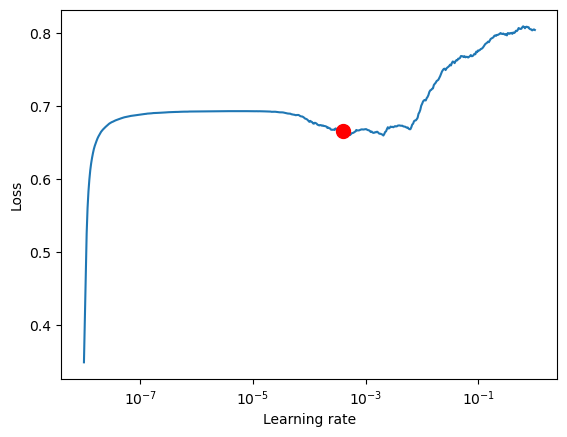

In [19]:
tuner = Tuner(trainer)

# Auto-scale batch size by growing it exponentially (default)
lr_finder = tuner.lr_find(model, mode="exponential", datamodule=dm, num_training=500)
fig = lr_finder.plot(suggest=True)
fig.show()


## Run training

In [20]:
trainer.fit(model, datamodule=dm)

Dataset already exists, skipping download and extraction...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | conv_1 | Sequential | 448   
1 | conv_2 | Sequential | 4.6 K 
2 | conv_3 | Sequential | 18.5 K
3 | fc_1   | Sequential | 11.1 M
4 | fc_2   | Sequential | 258   
--------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.530    Total estimated model params size (MB)


Dataset created, split:
training images: 19999
validation images: 4999


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## Tensorboard logs
We can use tensorboard to visualize our training metrics.

We can either manually start the tensorboard server and go to [localhost:6006](http://localhost:6006)

In [1]:
!tensorboard --logdir='./lightning_logs' --bind_all

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.13.0 at http://27b367440664:6006/ (Press CTRL+C to quit)
^C


The other possibility is to use the tensorboard extension directly in the notebook:

In [2]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs --bind_all

## Use profiler to find bottlenecks

In [45]:
trainer = pl.Trainer(max_epochs=1, profiler='simple')
trainer.fit(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Dataset already exists, skipping download and extraction...



  | Name   | Type       | Params
--------------------------------------
0 | conv_1 | Sequential | 448   
1 | conv_2 | Sequential | 4.6 K 
2 | conv_3 | Sequential | 18.5 K
3 | fc_1   | Sequential | 11.1 M
4 | fc_2   | Sequential | 258   
--------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.530    Total estimated model params size (MB)


Dataset created, split:
training images: 19999
validation images: 4999


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                   

## Early stopping callback

In [10]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

early_stop_cb = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    strict=False, 
    verbose=False, 
    mode="min"
)

## Model checkpoint callback

In [26]:
from lightning.pytorch.callbacks import ModelCheckpoint
checkpoint_cb = ModelCheckpoint(
    monitor="val_loss", 
    dirpath='models/', 
    filename='cat_vs_dogs-{epoch:02d}-{val_loss:.2f}', 
    save_top_k=3, #keep top 3 models
    mode="min"
)

## Custom callback

In [27]:
from lightning.pytorch.callbacks import Callback

class CustomPrintCallback(Callback):

    def on_init_start(self, trainer):
        print(f'on_init_start called, trainer: {trainer}')

    def on_init_end(self, trainer):
        print(f'on_init_end called, trainer: {trainer}')

    def on_train_end(self, trainer, pl_module):
        print(f'on_train_end called, trainer: {trainer}, module: {pl_module}')

In [28]:
trainer = pl.Trainer(max_epochs=1, callbacks=[early_stop_cb, checkpoint_cb, CustomPrintCallback()])
trainer.fit(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Dataset already exists, skipping download and extraction...


/home/user/mambaforge/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))

  | Name   | Type       | Params
--------------------------------------
0 | conv_1 | Sequential | 448   
1 | conv_2 | Sequential | 4.6 K 
2 | conv_3 | Sequential | 18.5 K
3 | fc_1   | Sequential | 11.1 M
4 | fc_2   | Sequential | 258   
--------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.530    Total estimated model params size (MB)


Dataset created, split:
training images: 19999
validation images: 4999


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


on_train_end called, trainer: <lightning.pytorch.trainer.trainer.Trainer object at 0x7f97c66aefd0>, module: SimpleCNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=43264, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
  )
  (fc_2): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [30]:
print(f'Best model score: {checkpoint_cb.best_model_score}, path:{checkpoint_cb.best_model_path}')

Best model score: 0.8199627995491028, path:/app/notebooks/models/cat_vs_dogs-epoch=00-val_loss=0.82.ckpt


## Restore best saved model

In [35]:
trained_model = SimpleCNN.load_from_checkpoint(batch_size=128, learning_rate=0.001, checkpoint_path = checkpoint_cb.best_model_path)
trained_model = trained_model.to(device)
trained_model.eval()

SimpleCNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=43264, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
  )
  (fc_2): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
)

## Export model in different formats

### torchscript
https://pytorch.org/docs/stable/jit.html

In [37]:
script_model = trained_model.to_torchscript()
torch.jit.save(script_model, "models/simple_cnn.pt")

### ONNX
ONNX aims to be a framework-agnostic standardformat for deep-learning models.

In [11]:
trained_model = SimpleCNN.load_from_checkpoint(batch_size=128, learning_rate=0.001, checkpoint_path = 'models/cat_vs_dogs-epoch=00-val_loss=0.82.ckpt')
trained_model = trained_model.to(device)
trained_model.eval()

input_sample = torch.randn(1, 3, 224, 224)
trained_model.to_onnx("models/simple_cnn.onnx", input_sample, export_params=True)

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



We can then use https://netron.app/ to visualize the model architecture.

## Validate servability of model
With lightning we can validate our model is production-ready even before training it.

In [22]:
from lightning.pytorch.serve import ServableModule, ServableModuleValidator
from typing import Dict, Optional

class ProductionReadyModel(SimpleCNN, ServableModule):
    def configure_payload(self):
        # 1: Access the train dataloader and load a single sample.
        image, _ = self.trainer.train_dataloader.dataset[0]

        # 2: Convert the image into a PIL Image to bytes and encode it with base64
        pil_image = T.ToPILImage()(image)
        buffered = BytesIO()
        pil_image.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode("UTF-8")

        return {"body": {"x": img_str}}

    def configure_serialization(self):
        return {"x": Image(224, 224).deserialize}, {"output": Top1().serialize}

    def serve_step(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        return {"output": self.model(x)}

    def configure_response(self):
        return {"output": 7}

Note: The following code will only work in a script called from a CLI as the ServableModuleValidator is designed to work from the CLI.

In [28]:
from lightning.pytorch.cli import LightningCLI
#cli = LightningCLI(
#    ProductionReadyModel,
#    CatDogImageDataModule,
#    seed_everything_default=42,
#    save_config_kwargs={"overwrite": True},
#    run=False,
#    trainer_defaults={
#        "accelerator": "cpu",
#        "callbacks": [ServableModuleValidator()],
#        "max_epochs": 1,
#        "limit_train_batches": 5,
#        "limit_val_batches": 5,
#    },
#)
#cli.trainer.fit(cli.model, cli.datamodule)